In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm
import seaborn as sns
import re
from jupyterthemes import jtplot
from datetime import timedelta, datetime
import calendar
import plotly.express as px
import sklearn.calibration
jtplot.style()

# Functions

Create rolling window of jobs started or ended in hour prior to each test

In [60]:
def rollmodel_df(x, dt_col, jobs_running = False):
    y = x.rename(columns = {'DATETIME' : dt_col}).drop(columns = ['JOBID'])
    df = pd.concat([slurm_jobs, y])
    df = df.sort_values(dt_col).reset_index(drop = True)
    if jobs_running == True:
        
        begin_load_df = (df[~df['JOBID'].isnull()]
                                  [['BEGIN']]
                                  .rename(columns={'BEGIN':'TIME'})
                        )
        begin_load_df['process'] = 1
        
        end_load_df = (df[~df['JOBID'].isnull()]
                                  [['END']]
                                  .rename(columns={'END':'TIME'})
                      )
        end_load_df['process'] = -1 
        
        commands_load_df = (df[df['JOBID'].isnull()]
                                  [[dt_col]]
                                  .rename(columns={dt_col:'TIME'})
                      )
        commands_load_df['process'] = 0 
        
        load_df = begin_load_df.append(end_load_df).append(commands_load_df)
        jobs_running_prefilter = load_df.sort_values('TIME')['process'].cumsum()
        jobs_running = jobs_running_prefilter[~jobs_running_prefilter
                                                  .index
                                                  .duplicated(keep='first')]
        df['JOBSRUNNING'+dt_col] = jobs_running
    else:
        df['ROLL1HR'+dt_col] = (df
                                   .rolling('1h', on = dt_col)
                                    ['JOBID']
                                    .count()
                                )
    df = df[df['JOBID'].isnull()]
    df = df[(df[dt_col] < '2021-05-18') | (df[dt_col] >= '2021-06-01')]
    return df

Logistic (unwraps Logit)

In [61]:
def logistic(x, a, b):
    return 1/(1+np.exp(-(a + (b*x))))

# Read in ce, filter down to testing
*testing* is the combined server logs (*ce*) filtered down to user 9204 and command type "sbatch".

In [62]:
ce = pd.read_csv('../data/ce.csv')

In [63]:
# Set some datatypes
ce['DATETIME'] = pd.to_datetime(ce['DATETIME'])
ce['UNRESPONSIVE'] = ce['UNRESPONSIVE'].astype('boolean')

In [65]:
testing = ce[ce['TESTING']]

# Read in slurm_jobs
We remove ROLL1HR because we want those values to roll over the *testing* values that we'll concatenate in.

In [66]:
slurm_jobs = pd.read_csv('../data/slurm_jobs.csv')

In [67]:
# Set our datetimes and timedeltas
datetime_cols = ['BEGIN', 'END']
for col in datetime_cols:
    slurm_jobs[col] = pd.to_datetime(slurm_jobs[col])

timedelta_cols = ['REQTIME', 'USEDTIME']
for col in timedelta_cols:
    slurm_jobs[col] = pd.to_timedelta(slurm_jobs[col])

In [68]:
# We'll put this back in the right context later
slurm_jobs = slurm_jobs.drop(columns = 'ROLL1HR')

## Problem 4

Combine the time series information from the two datasets together to see 

(4A) how well correlated heavy job-completion load is with the unresponsiveness, and 

(4B) to see if there is some threshold of job completions per hour that generally results in unresponsiveness.

## (4A) How well correlated is heavy job-ending load with unresponsiveness?

Run the rollmodel_df function defined earlier to do the following:

-- Mix in logs (*testing*) with jobs (*slurm_jobs*)

   * concatenate *slurm_jobs* and testing; call it *slurm_testing_END*
    
-- Create rolling window to check for unresponsivenss

   * sort and reset index of *slurm_testing*
   * create rolling window for jobs completed in hour prior to each entry; call the column ROLL1HR
   * filter slurm_testing down to TESTING == True
   * ensure UNRESPONSIVE is boolean
   * filter out late-May downtime

In [70]:
slurm_testing_END = rollmodel_df(testing, 'END')

### Make logistic regression model: ROLL1HR model shows AIC improvement over base model. 

### Result: Significant: ROLL1HR and UNRESPONSIVE are (slightly) negatively correlated.

Odds of unresponsiveness decrease by 8% with every thousand jobs ended per hour; e.g. the odds of unresponsiveness at 2000 jobs are predicted to be about 92.7% of what they are at 1000 jobs.

In [71]:
logreg_unresponsive_base = (sm.GLM(endog = slurm_testing_END['UNRESPONSIVE'].astype('int'),
                       exog = sm.add_constant(slurm_testing_END[[]]),
                       family = sm.families.Binomial(),
                      )
                  .fit()
               )

logreg_unresponsive_roll = (sm.GLM(endog = slurm_testing_END['UNRESPONSIVE'].astype('int'),
                       exog = sm.add_constant(slurm_testing_END['ROLL1HREND']),
                       family = sm.families.Binomial(),
                      )
                  .fit()
               )
print(logreg_unresponsive_roll.summary(), '\n\n')
print('Base AIC: '+str(logreg_unresponsive_base.aic))
print('Logistic AIC: '+str(logreg_unresponsive_roll.aic))

                 Generalized Linear Model Regression Results                  
Dep. Variable:           UNRESPONSIVE   No. Observations:                58782
Model:                            GLM   Df Residuals:                    58780
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -12505.
Date:                Mon, 08 Nov 2021   Deviance:                       25011.
Time:                        22:52:16   Pearson chi2:                 5.88e+04
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.7876      0.023   -121.772      0.0

### Plot the model with regular axes

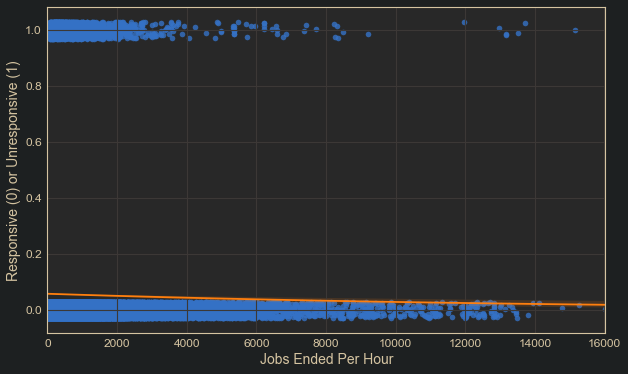

In [72]:
fontsize = 14

fig, ax = plt.subplots(figsize = (10, 6))
sns.regplot(x = 'ROLL1HREND', 
            y = slurm_testing_END['UNRESPONSIVE'].astype('int'), 
            data = slurm_testing_END, 
            logistic = True, 
            line_kws = {"color": "#FF7F0E"}, 
            y_jitter = 0.03, 
            ax = ax
)

plt.ylabel("Responsive (0) or Unresponsive (1)", fontsize = fontsize)
plt.yticks(fontsize = fontsize - 2)
plt.xticks(fontsize = fontsize - 2)
plt.xlabel("Jobs Ended Per Hour", fontsize = fontsize);
plt.savefig('../images/jobs_ended_logreg.png', dpi = 600)

## Build model with all commands, not just USER 9204 and COMMANDTYPE sbatch

### Result: Different coefficients but same takeaway: small negative correlation.

In [74]:
slurm_allcomf = rollmodel_df(ce, 'END')

In [75]:
logreg_unresponsive_base = (sm.GLM(endog = slurm_allcomf['UNRESPONSIVE'].astype('int'),
                       exog = sm.add_constant(slurm_allcomf[[]]),
                       family = sm.families.Binomial(),
                      )
                  .fit()
               )

logreg_unresponsive_roll = (sm.GLM(endog = slurm_allcomf['UNRESPONSIVE'].astype('int'),
                       exog = sm.add_constant(slurm_allcomf['ROLL1HREND']),
                       family = sm.families.Binomial(),
                      )
                  .fit()
               )
print(logreg_unresponsive_roll.summary(), '\n\n')
print('Base AIC: '+str(logreg_unresponsive_base.aic))
print('Logistic AIC: '+str(logreg_unresponsive_roll.aic))

                 Generalized Linear Model Regression Results                  
Dep. Variable:           UNRESPONSIVE   No. Observations:              9406878
Model:                            GLM   Df Residuals:                  9406876
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -3.2030e+06
Date:                Mon, 08 Nov 2021   Deviance:                   6.4060e+06
Time:                        22:56:06   Pearson chi2:                 9.48e+06
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.9778      0.001  -1416.503      0.0

## Model with TESTING and jobs begun

### Result: Different coefficients but same takeaway: small negative correlation.

In [76]:
slurm_testing_BEGIN = rollmodel_df(testing, 'BEGIN')

In [77]:
logreg_unresponsive_base = (sm.GLM(endog = slurm_testing_BEGIN['UNRESPONSIVE'].astype('int'),
                       exog = sm.add_constant(slurm_testing_BEGIN[[]]),
                       family = sm.families.Binomial(),
                      )
                  .fit()
               )

logreg_unresponsive_roll = (sm.GLM(endog = slurm_testing_BEGIN['UNRESPONSIVE'].astype('int'),
                       exog = sm.add_constant(slurm_testing_BEGIN['ROLL1HRBEGIN']),
                       family = sm.families.Binomial(),
                      )
                  .fit()
               )
print(logreg_unresponsive_roll.summary(), '\n\n')
print('Base AIC: '+str(logreg_unresponsive_base.aic))
print('Logistic AIC: '+str(logreg_unresponsive_roll.aic))

                 Generalized Linear Model Regression Results                  
Dep. Variable:           UNRESPONSIVE   No. Observations:                58782
Model:                            GLM   Df Residuals:                    58780
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -12511.
Date:                Mon, 08 Nov 2021   Deviance:                       25023.
Time:                        22:56:26   Pearson chi2:                 5.88e+04
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -2.8161      0.022   -126.153   

## Model with TESTING and jobs simultaneously running

### Result: Significant: Jobs simultaneously running is positively correlated with unresponsiveness.

In [78]:
slurm_testing_JOBSRUNNING = rollmodel_df(testing, 'BEGIN', True)

In [80]:
logreg_unresponsive_base = (sm.GLM(endog = slurm_testing_JOBSRUNNING['UNRESPONSIVE'].astype('int'),
                       exog = sm.add_constant(slurm_testing_JOBSRUNNING[[]]),
                       family = sm.families.Binomial(),
                      )
                  .fit()
               )

logreg_unresponsive_roll = (sm.GLM(endog = slurm_testing_JOBSRUNNING['UNRESPONSIVE'].astype('int'),
                       exog = sm.add_constant(slurm_testing_JOBSRUNNING['JOBSRUNNINGBEGIN']),
                       family = sm.families.Binomial(),
                      )
                  .fit()
               )
print(logreg_unresponsive_roll.summary(), '\n\n')
print('Base AIC: '+str(logreg_unresponsive_base.aic))
print('Logistic AIC: '+str(logreg_unresponsive_roll.aic))

                 Generalized Linear Model Regression Results                  
Dep. Variable:           UNRESPONSIVE   No. Observations:                58782
Model:                            GLM   Df Residuals:                    58780
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -11991.
Date:                Mon, 08 Nov 2021   Deviance:                       23982.
Time:                        22:56:43   Pearson chi2:                 5.74e+04
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -5.1497      0.081  

### Plot the model

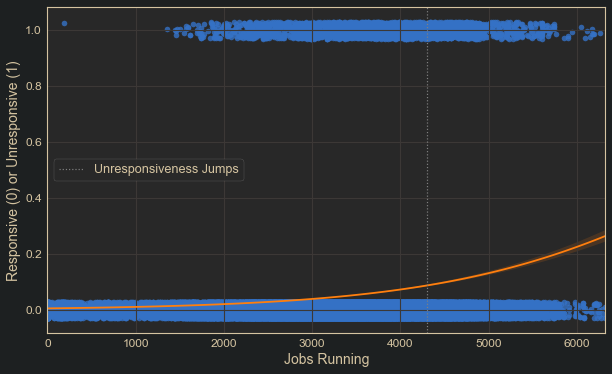

In [81]:
fontsize = 14

fig, ax = plt.subplots(figsize = (10, 6))
sns.regplot(x = 'JOBSRUNNINGBEGIN', 
            y = slurm_testing_JOBSRUNNING['UNRESPONSIVE'].astype('int'), 
            data = slurm_testing_JOBSRUNNING, 
            logistic = True, 
            line_kws = {"color": "#FF7F0E"}, 
            y_jitter = 0.03, 
            ax = ax
)
ax.axvline(x = 4300, color = 'gray', linestyle = ':', label = 'Unresponsiveness Jumps')
plt.legend()
plt.ylabel("Responsive (0) or Unresponsive (1)", fontsize = fontsize)
plt.yticks(fontsize = fontsize - 2)
plt.xticks(fontsize = fontsize - 2)
plt.xlabel("Jobs Running", fontsize = fontsize);
plt.savefig('../images/jobs_running_logreg.png', dpi = 600)

### Check the model's calibration
(pretty good)

<AxesSubplot:xlabel='Predicted Probability of Unresponsiveness', ylabel='True Probability of Unresponsiveness'>

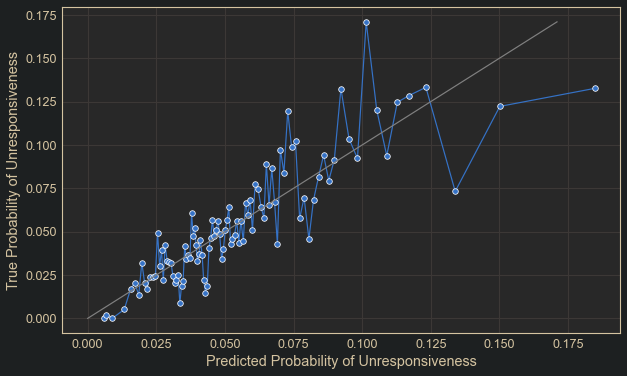

In [82]:
prob_true, prob_pred = sklearn.calibration.calibration_curve(
                                slurm_testing_JOBSRUNNING['UNRESPONSIVE'].astype('int'), 
                                logreg_unresponsive_roll.fittedvalues,
                                strategy = 'quantile',
                                n_bins = 100
                                     )
fig, ax = plt.subplots(figsize = (10,6))
sns.lineplot(x = prob_pred, y = prob_true, ax = ax, marker = 'o')
ax.set(xlabel = 'Predicted Probability of Unresponsiveness',
       ylabel = 'True Probability of Unresponsiveness')
sns.lineplot(x = prob_true, y = prob_true, color = 'gray', )

### Look for any thresholds where unresponsiveness jumps
The biggest jump is around 4,300 simultaneous jobs (up to 11.7%)

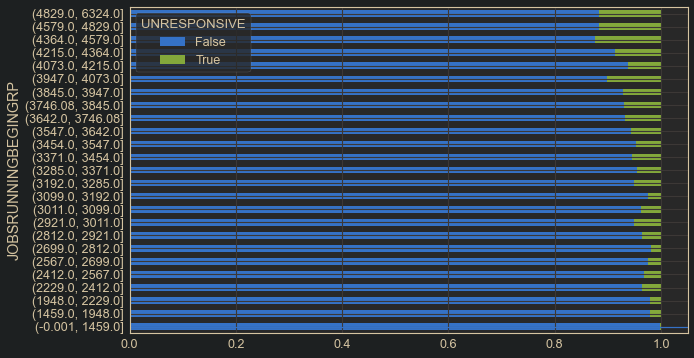

In [83]:
slurm_testing_JOBSRUNNING['JOBSRUNNINGBEGINGRP'] = pd.qcut(slurm_testing_JOBSRUNNING['JOBSRUNNINGBEGIN'], 
                                                           q = 25)
fig, ax = plt.subplots(figsize = (10,6))

(slurm_testing_JOBSRUNNING
         .groupby(['JOBSRUNNINGBEGINGRP', 'UNRESPONSIVE'])
         ['JOBSRUNNINGBEGINGRP']
         .count()/slurm_testing_JOBSRUNNING
                     .groupby('JOBSRUNNINGBEGINGRP')
                     ['JOBSRUNNINGBEGINGRP']
                     .count()
).unstack().plot(kind = 'barh', 
       stacked = True, 
       ax = ax)
ax.axhline();

### Confirming the actual percentages of the plot above

In [84]:
(slurm_testing_JOBSRUNNING
         .groupby(['JOBSRUNNINGBEGINGRP', 'UNRESPONSIVE'])
         ['JOBSRUNNINGBEGINGRP']
         .count()/slurm_testing_JOBSRUNNING
                     .groupby('JOBSRUNNINGBEGINGRP')
                     ['JOBSRUNNINGBEGINGRP']
                     .count()
).tail(24)

JOBSRUNNINGBEGINGRP  UNRESPONSIVE
(3371.0, 3454.0]     False           0.945809
                     True            0.054191
(3454.0, 3547.0]     False           0.952502
                     True            0.047498
(3547.0, 3642.0]     False           0.942833
                     True            0.057167
(3642.0, 3746.08]    False           0.931993
                     True            0.068007
(3746.08, 3845.0]    False           0.929655
                     True            0.070345
(3845.0, 3947.0]     False           0.928205
                     True            0.071795
(3947.0, 4073.0]     False           0.898600
                     True            0.101400
(4073.0, 4215.0]     False           0.938136
                     True            0.061864
(4215.0, 4364.0]     False           0.914015
                     True            0.085985
(4364.0, 4579.0]     False           0.876223
                     True            0.123777
(4579.0, 4829.0]     False           0.883178


### Identifying the maximum predicted probability of unresponsiveness
About 26.5%

In [85]:
logreg_unresponsive_roll.fittedvalues.max()

0.2645790438037419

# APPENDIX: Valley of Dry Bones

Original code for checking unresponsiveness

In [87]:
# regex = re.compile(r'((?P<hours>\d+?)h)?((?P<minutes>\d+?)m)?((?P<seconds>\d+?)s)?')

# def parse_time(time_str):
#     parts = regex.match(time_str)
#     if not parts:
#         return
#     parts = parts.groupdict()
#     time_params = {}
#     for name, param in parts.items():
#         if param:
#             time_params[name] = int(param)
#     return timedelta(**time_params)

In [88]:
# def check_unresponsive(x, window = '1h'):
#     cef = ce.loc[(ce['DATETIME'] >= x - parse_time(window))
#                  &
#                  (ce['DATETIME'] <= x)]
#     unresp = cef['UNRESPONSIVE'].any()
#     return unresp

In [89]:
#slurm_jobs['END'].apply(check_unresponsive)

George's code for concurrent processes

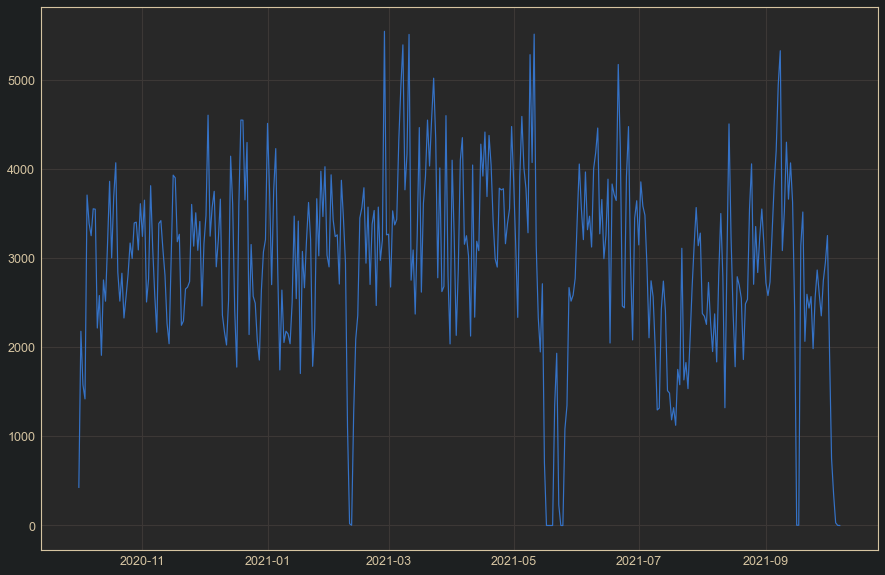

In [90]:
# # George's concurrent processes code
# begin_load_df = slurm_jobs[slurm_jobs['PARTITION'] == 'production'][['BEGIN']].rename(columns={'BEGIN':'TIME'})
# begin_load_df['process'] = 1
# end_load_df = slurm_jobs[slurm_jobs['PARTITION'] == 'production'][['END']].rename(columns={'END':'TIME'})
# end_load_df['process'] = -1 
# load_df = begin_load_df.append(end_load_df)
# resample_interval = "D" 
# fs_ts = pd.Series(list(load_df['process']), index=list(load_df['TIME']))
# fs_resample = fs_ts.resample(resample_interval).sum().to_frame().cumsum()
# plt.figure(figsize=(15, 10))
# plt.plot(fs_resample.index, fs_resample[0])

Useful stripplots with mean hlines

In [ ]:
# fline = slurm_tests_filt.loc[slurm_tests['UNRESPONSIVE'] == False, 'ROLL1HR'].mean()
# tline = slurm_tests_filt.loc[slurm_tests['UNRESPONSIVE'] == True, 'ROLL1HR'].mean()

# ax = sns.stripplot(data = slurm_tests_filt, x = 'UNRESPONSIVE', y = 'ROLL1HR')
# ax.axhline(fline)
# ax.axhline(tline, color = '#83A83B')

In [ ]:
# fline = slurm_tests_filt.loc[slurm_tests['UNRESPONSIVE'] == False, 'ROLL1HR'].mean()
# tline = slurm_tests_filt.loc[slurm_tests['UNRESPONSIVE'] == True, 'ROLL1HR'].mean()

# ax = sns.stripplot(data = slurm_tests_filt, x = 'UNRESPONSIVE', y = 'ROLL1HR')
# ax.set(yscale = 'log')
# ax.axhline(fline)
# ax.axhline(tline, color = '#83A83B')

datetime diffs from single column and ecdf

In [ ]:
# print(testing['END'].diff().describe())
# x = testing['END'].diff().apply(lambda x: x.total_seconds()).to_frame()
# sns.displot(x,  
#             kind = 'ecdf',
#            )
# plt.xlim(0.001, 1800)

Some plot templates used before switching to regplot()

In [ ]:
# fontsize = 16

# fig, ax = plt.subplots(figsize = (10,6))

# x = slurm_testing_END['ROLL1HREND']
# y_logistic = logistic(x = x, a = -2.7876, b =-7.347e-05)
# plt.scatter(x, y_logistic, label = 'Logistic')

# x = slurm_testing_END['ROLL1HREND']
# y = slurm_testing_END['UNRESPONSIVE'].astype('int')
# plt.scatter(x, y, label = 'Actual', alpha = 0.5)
# #ax.axhline(0.5)
# plt.legend()
# #plt.title("Logistic Regression Model Predicts Unresponsiveness Decreases as Jobs Ended Per Hour Increases")
# plt.ylabel("Responsive (0) or Unresponsive (1)", fontsize = fontsize)
# plt.yticks(fontsize = fontsize - 2)
# plt.xticks(fontsize = fontsize - 2)
# plt.xlabel("Jobs Ended Per Hour", fontsize = fontsize);


In [ ]:
# fig, ax = plt.subplots(figsize = (10,6))

# x = slurm_testing_JOBSRUNNING['JOBSRUNNINGBEGIN']
# y_logistic = logistic(x = x, a = -5.1497, b =0.0007)
# plt.scatter(x, y_logistic, label = 'Logistic')

# x = slurm_testing_JOBSRUNNING['JOBSRUNNINGBEGIN']
# y = slurm_testing_JOBSRUNNING['UNRESPONSIVE'].astype('int')
# plt.scatter(x, y, label = 'Actual', alpha = 0.5)
# #ax.axhline(0.5)
# plt.legend()
# plt.title("Logistic Regression Model Predicts Unresponsiveness Increases as Jobs Running Increases")
# plt.ylabel("Responsive (0) or Unresponsive (1)")
# plt.xlabel("Jobs Running");